# Predicting House Prices with Apache Spark

- [1.- Understanding the Data Set](#1) 
- [2.- Import](#2)
- [3.- Creating the Spark Session](#3)
- [4.- Load the data from a file into a DataFrame](#4)
- [5.- Data Exploration](#5)
- [6.- Data Preprocessing](#6)
- [7.- Feature Engineering](#7)
- [8.- Building A Machine Learning Model With Spark ML](#8)
- [9.- Inspect the Model Co-efficients](#9)

# 1
### Understanding the Data Set

Data set:https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

**Longitude:** refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

**Latitude:** refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

**Housing Median Age:** is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values

**Total Rooms:** is the total number of rooms in the houses per block group

**Total Bedrooms:** is the total number of bedrooms in the houses per block group

**Population:** is the number of inhabitants of a block group

**Households:** refers to units of houses and their occupants per block group

**Median Income:** is used to register the median income of people that belong to a block group

**Median House Value:** is the dependent variable and refers to the median house value per block group

# 2
### Import 

In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# 3
### Creating the Spark Session

In [6]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()
spark

23/10/26 12:47:39 WARN Utils: Your hostname, abel-Surface-Pro resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
23/10/26 12:47:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/26 12:47:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/26 12:47:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/home/patricia/miniconda3/envs/pyspark/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# 4 
### Load the data from a file into a DataFrame

In [16]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("median_age", FloatType(), nullable=True),
    StructField("total_rooms", FloatType(), nullable=True),
    StructField("total_bdrms", FloatType(), nullable=True),
    StructField("population", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [56]:
# Load housing data
housing_df = spark.read.csv(path='./data/cal_housing.data', schema=schema).cache()


23/10/26 15:35:53 WARN CacheManager: Asked to cache already cached data.


In [57]:
# Insepct first five rows
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, median_age=41.0, total_rooms=880.0, total_bdrms=129.0, population=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, median_age=21.0, total_rooms=7099.0, total_bdrms=1106.0, population=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, median_age=52.0, total_rooms=1467.0, total_bdrms=190.0, population=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, median_age=52.0, total_rooms=1274.0, total_bdrms=235.0, population=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, median_age=52.0, total_rooms=1627.0, total_bdrms=280.0, population=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [58]:
# Show first five rows
housing_df.show(5)

+-------+-----+----------+-----------+-----------+----------+--------+------+--------+
|   long|  lat|median_age|total_rooms|total_bdrms|population|houshlds|medinc|   medhv|
+-------+-----+----------+-----------+-----------+----------+--------+------+--------+
|-122.23|37.88|      41.0|      880.0|      129.0|     322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|      21.0|     7099.0|     1106.0|    2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|      52.0|     1467.0|      190.0|     496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|      52.0|     1274.0|      235.0|     558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|      52.0|     1627.0|      280.0|     565.0|   259.0|3.8462|342200.0|
+-------+-----+----------+-----------+-----------+----------+--------+------+--------+
only showing top 5 rows



In [59]:
# show the dataframe columns
housing_df.columns

['long',
 'lat',
 'median_age',
 'total_rooms',
 'total_bdrms',
 'population',
 'houshlds',
 'medinc',
 'medhv']

In [60]:
# show the schema of the dataframe
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bdrms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



# 5
### Data Exploration

In [61]:
# run a sample selection
housing_df.select('population','total_bdrms').show(10)

+----------+-----------+
|population|total_bdrms|
+----------+-----------+
|     322.0|      129.0|
|    2401.0|     1106.0|
|     496.0|      190.0|
|     558.0|      235.0|
|     565.0|      280.0|
|     413.0|      213.0|
|    1094.0|      489.0|
|    1157.0|      687.0|
|    1206.0|      665.0|
|    1551.0|      707.0|
+----------+-----------+
only showing top 10 rows



#### 5.1 Distribution of the median age of the people living in the area:

In [62]:
# groupBy dt by median_age and see the distribution
result_df = housing_df.groupBy('median_age').count().sort("median_age",ascending = False)

In [63]:
result_df.show(10)

+----------+-----+
|median_age|count|
+----------+-----+
|      52.0| 1273|
|      51.0|   48|
|      50.0|  136|
|      49.0|  134|
|      48.0|  177|
|      47.0|  198|
|      46.0|  245|
|      45.0|  294|
|      44.0|  356|
|      43.0|  353|
+----------+-----+
only showing top 10 rows



<Axes: xlabel='median_age'>

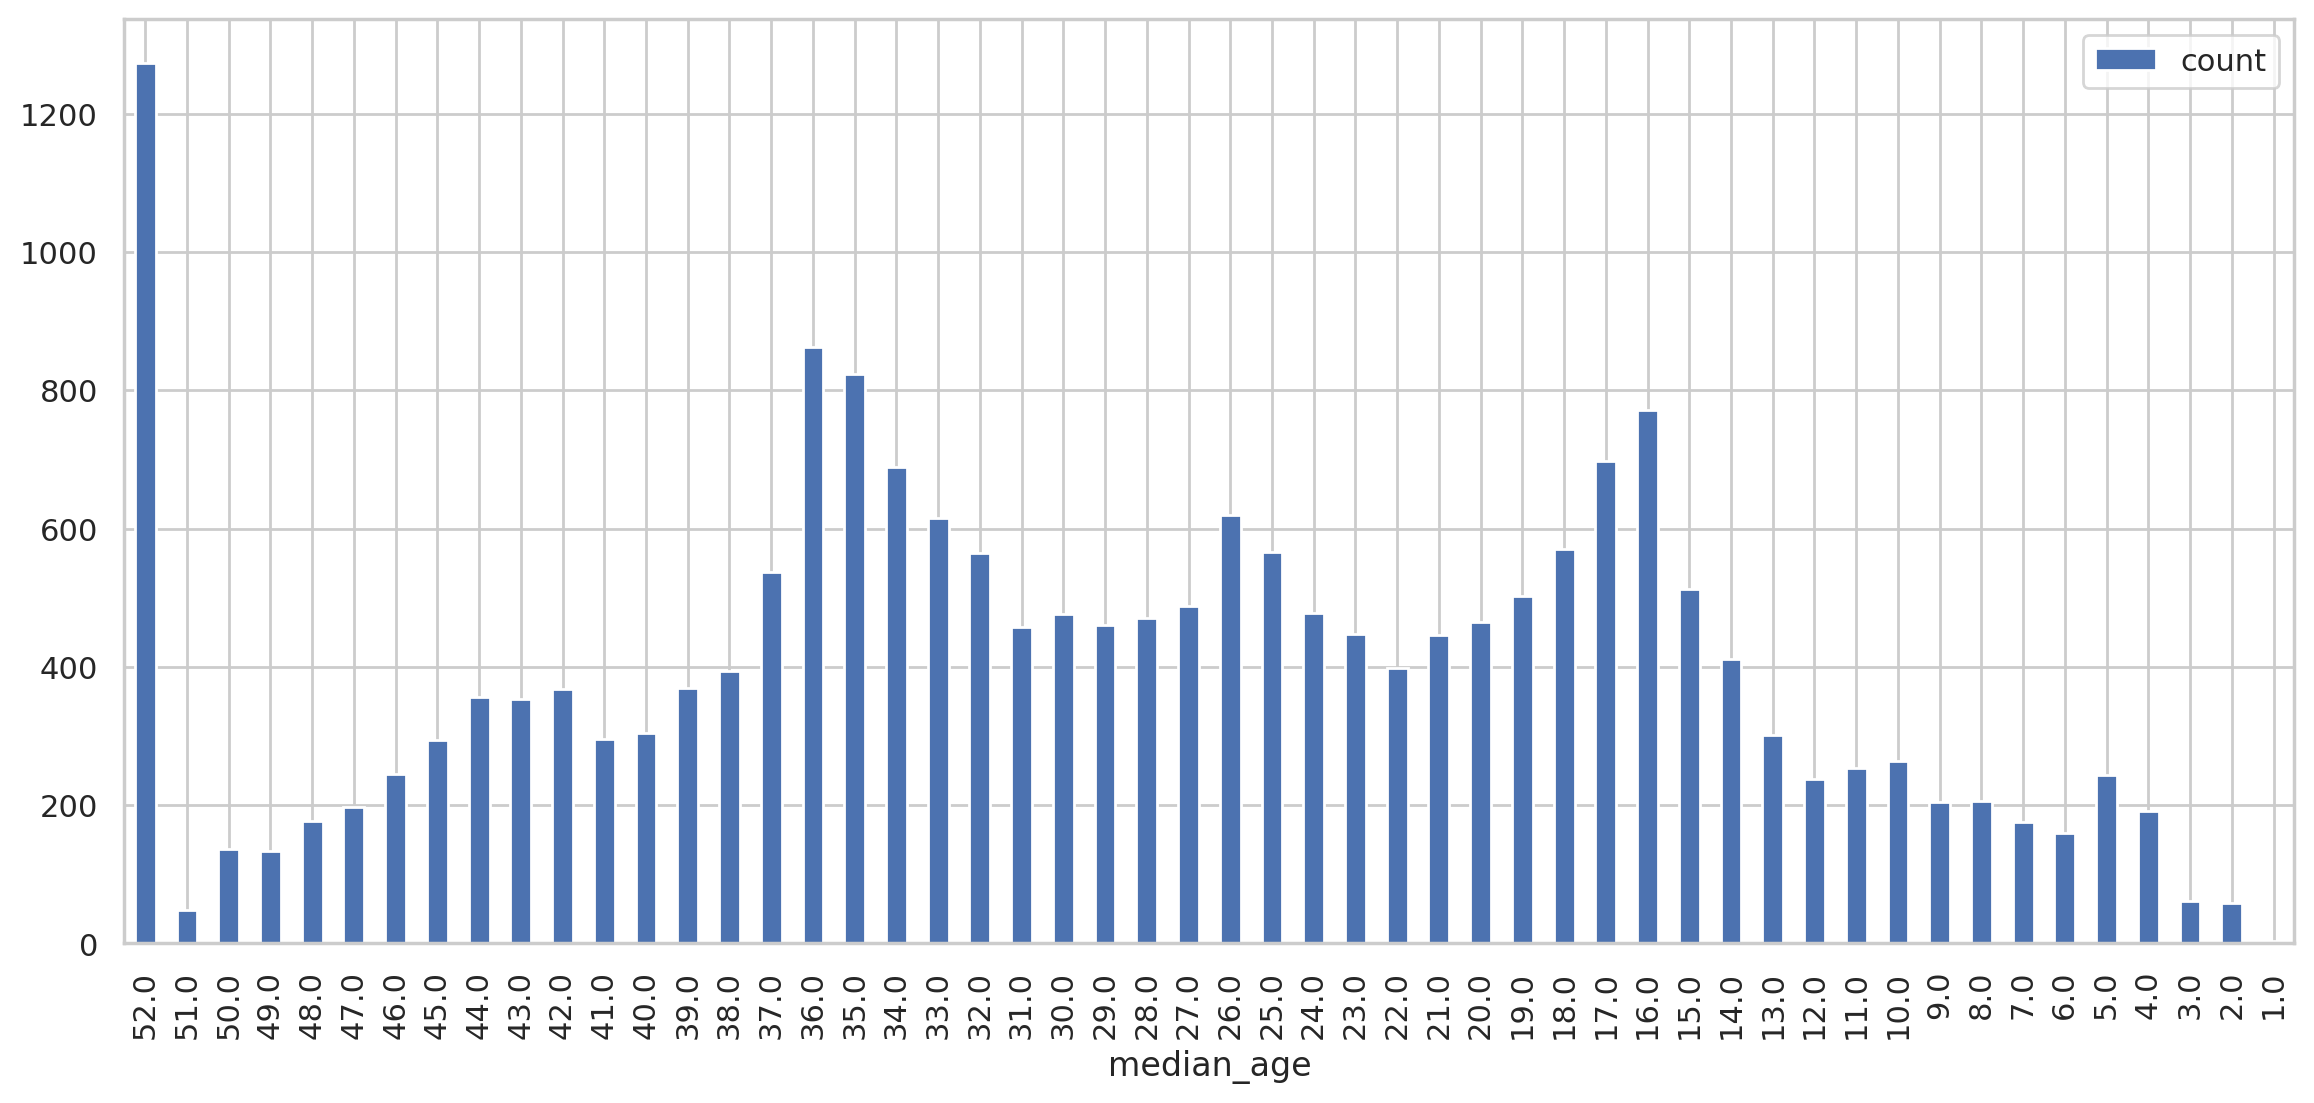

In [27]:
result_df.toPandas().plot.bar(x='median_age',figsize=(14,6))

Most of the residents are either in their youth or they settle here during their senior years. Some data are showing median age < 10 which seems to be out of place.

#### 5.2 Summary Statistics:

In [64]:
housing_df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|               long|              lat|        median_age|       total_rooms|      total_bdrms|        population|         houshlds|            medinc|             medhv|
+-------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|            20640|             20640|            20640|             20640|             20640|
|   mean|-119.56970444871473|35.63186143109965|28.639486434108527|2635.7630813953488|537.8980135658915|1425.4767441860465|499.5396802325581|3.8706710030346416|206855.81690891474|
| stddev|  2.003531742932898|2.135952380602968| 12.58555761211163|2181.6152515827944| 421.247905943133|  

In [65]:
housing_df.describe().select(
    "summary",
    F.round("median_age",4).alias('median_age'),
    F.round('total_rooms',4).alias('total_rooms'),
    F.round('total_bdrms',4).alias('total_bdrms'),
    F.round('population',4).alias('population'),
    F.round("houshlds", 4).alias("houshlds"),
    F.round("medinc", 4).alias("medinc"),
    F.round("medhv", 4).alias("medhv")
).show()


+-------+----------+-----------+-----------+----------+--------+-------+-----------+
|summary|median_age|total_rooms|total_bdrms|population|houshlds| medinc|      medhv|
+-------+----------+-----------+-----------+----------+--------+-------+-----------+
|  count|   20640.0|    20640.0|    20640.0|   20640.0| 20640.0|20640.0|    20640.0|
|   mean|   28.6395|  2635.7631|    537.898| 1425.4767|499.5397| 3.8707|206855.8169|
| stddev|   12.5856|  2181.6153|   421.2479| 1132.4621|382.3298| 1.8998|115395.6159|
|    min|       1.0|        2.0|        1.0|       3.0|     1.0| 0.4999|    14999.0|
|    max|      52.0|    39320.0|     6445.0|   35682.0|  6082.0|15.0001|   500001.0|
+-------+----------+-----------+-----------+----------+--------+-------+-----------+



Look at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

# 6
### Data Preprocessing

#### 6.1 Preprocessing The Target Values

First, let's start with the `medianHouseValue`, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

In [66]:
housing_df = housing_df.withColumn("medhv",col("medhv")/100000)
housing_df.show(2)

+-------+-----+----------+-----------+-----------+----------+--------+------+-----+
|   long|  lat|median_age|total_rooms|total_bdrms|population|houshlds|medinc|medhv|
+-------+-----+----------+-----------+-----------+----------+--------+------+-----+
|-122.23|37.88|      41.0|      880.0|      129.0|     322.0|   126.0|8.3252|4.526|
|-122.22|37.86|      21.0|     7099.0|     1106.0|    2401.0|  1138.0|8.3014|3.585|
+-------+-----+----------+-----------+-----------+----------+--------+------+-----+
only showing top 2 rows



In [67]:
from pyspark.sql.functions import col,isnan,when,count
df_Columns = housing_df.columns
housing_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns]
   ).show()

+----+---+----------+-----------+-----------+----------+--------+------+-----+
|long|lat|median_age|total_rooms|total_bdrms|population|houshlds|medinc|medhv|
+----+---+----------+-----------+-----------+----------+--------+------+-----+
|   0|  0|         0|          0|          0|         0|       0|     0|    0|
+----+---+----------+-----------+-----------+----------+--------+------+-----+



# 7
### Feature Engineering

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

- Rooms per household which refers to the number of rooms in households per block group;
- Population per household, which basically gives us an indication of how many people live in households per block group; And
- Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the `select()` method to select the columns that we're going to be working with, namely `totalRooms`, `households`, and `population`. Additionally, we have to indicate that we're working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

In [68]:
housing_df.columns

['long',
 'lat',
 'median_age',
 'total_rooms',
 'total_bdrms',
 'population',
 'houshlds',
 'medinc',
 'medhv']

In [69]:
# Add the new columns to df
housing_df = (
    housing_df.withColumn("rooms_per_hs", F.round(col("total_rooms")/col("houshlds"),2))
    .withColumn("population_per_hs", F.round(col("population")/col("houshlds"),2))
    .withColumn("bedrooms_per_rooms", F.round(col("total_bdrms")/col("total_rooms"),2))
)

In [70]:
housing_df.show(5)


+-------+-----+----------+-----------+-----------+----------+--------+------+-----+------------+-----------------+------------------+
|   long|  lat|median_age|total_rooms|total_bdrms|population|houshlds|medinc|medhv|rooms_per_hs|population_per_hs|bedrooms_per_rooms|
+-------+-----+----------+-----------+-----------+----------+--------+------+-----+------------+-----------------+------------------+
|-122.23|37.88|      41.0|      880.0|      129.0|     322.0|   126.0|8.3252|4.526|        6.98|             2.56|              0.15|
|-122.22|37.86|      21.0|     7099.0|     1106.0|    2401.0|  1138.0|8.3014|3.585|        6.24|             2.11|              0.16|
|-122.24|37.85|      52.0|     1467.0|      190.0|     496.0|   177.0|7.2574|3.521|        8.29|              2.8|              0.13|
|-122.25|37.85|      52.0|     1274.0|      235.0|     558.0|   219.0|5.6431|3.413|        5.82|             2.55|              0.18|
|-122.25|37.85|      52.0|     1627.0|      280.0|     565.0| 

We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14:

Since we don't want to necessarily standardize our target values, we'll want to make sure to isolate those in our data set. Note also that this is the time to leave out variables that we might not want to consider in our analysis. In this case, let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

In this case, we will use the `select()` method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

In [71]:
housing_df.columns

['long',
 'lat',
 'median_age',
 'total_rooms',
 'total_bdrms',
 'population',
 'houshlds',
 'medinc',
 'medhv',
 'rooms_per_hs',
 'population_per_hs',
 'bedrooms_per_rooms']

In [72]:
# Re-order and select columns
housing_df = housing_df.select("medhv",
                               "total_bdrms",
                               "population",
                               "houshlds",
                               "medinc",
                               "rooms_per_hs",
                               "population_per_hs",
                               "bedrooms_per_rooms"
                              )

In [73]:
housing_df.show(3)

+-----+-----------+----------+--------+------+------------+-----------------+------------------+
|medhv|total_bdrms|population|houshlds|medinc|rooms_per_hs|population_per_hs|bedrooms_per_rooms|
+-----+-----------+----------+--------+------+------------+-----------------+------------------+
|4.526|      129.0|     322.0|   126.0|8.3252|        6.98|             2.56|              0.15|
|3.585|     1106.0|    2401.0|  1138.0|8.3014|        6.24|             2.11|              0.16|
|3.521|      190.0|     496.0|   177.0|7.2574|        8.29|              2.8|              0.13|
+-----+-----------+----------+--------+------+------------+-----------------+------------------+
only showing top 3 rows



#### 7.1 Feature Extraction

In [74]:
featureCols = ["total_bdrms","population","houshlds","medinc","rooms_per_hs","population_per_hs",
               "bedrooms_per_rooms"]

#### Use a VectorAssembler to put features into a feature vector column:

In [75]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [76]:
assembler_df = assembler.transform(housing_df)

In [77]:
assembler_df.show(10, truncate = False)

+-----+-----------+----------+--------+------+------------+-----------------+------------------+-------------------------------------------------------+
|medhv|total_bdrms|population|houshlds|medinc|rooms_per_hs|population_per_hs|bedrooms_per_rooms|features                                               |
+-----+-----------+----------+--------+------+------------+-----------------+------------------+-------------------------------------------------------+
|4.526|129.0      |322.0     |126.0   |8.3252|6.98        |2.56             |0.15              |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0     |2401.0    |1138.0  |8.3014|6.24        |2.11             |0.16              |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0      |496.0     |177.0   |7.2574|8.29        |2.8              |0.13              |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0      |558.0     |219.0   |5.6431|5.82        |2.55             |0.18 

#### 7.2 Standardization

Next, we can finally scale the data using `StandardScaler`. The input columns are the `features`, and the output column with the rescaled that will be included in the scaled_df will be named `"features_scaled"`:



In [79]:
# Initialize the standardScaler
standardScaler = StandardScaler(inputCol="features",outputCol="features_scaled")

In [81]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembler_df).transform(assembler_df)

In [82]:
scaled_df.select(
    "features",
    "features_scaled"
).show(10, truncate = False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

# 8
### Building A Machine Learning Model With Spark ML

With all the preprocessing done, it's finally time to start building our Linear Regression model! Just like always, we first need to split the data into training and test sets. Luckily, this is no issue with the `randomSplit()` method:

In [84]:
train_data, test_data = scaled_df.randomSplit([.8,.2], seed = rnd_seed)

In [85]:
train_data.columns

['medhv',
 'total_bdrms',
 'population',
 'houshlds',
 'medinc',
 'rooms_per_hs',
 'population_per_hs',
 'bedrooms_per_rooms',
 'features',
 'features_scaled']

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

![img](./img/house2.png)
 
http://scikit-learn.org/stable/modules/linear_model.html#elastic-net



In [86]:
lr = (LinearRegression(featuresCol='features_scaled',labelCol="medhv",predictionCol='predmedhv',
                      maxIter = 10, regParam = 0.3, elasticNetParam = 0.8,standardization = False))

In [87]:
linearModel = lr.fit(train_data)

23/10/26 16:20:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


# 9
### Inspect the Model Co-efficients

In [88]:
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])